<font size="5.5"><u><i>Populations Explorer</i></u></font>

<font size="4">Script to explore population of samples: multiple waveforms + noise</font>
<br/>
<font size="4">Author: Manuel David Morales</font>

## 1. Library imports

In [1]:
# Data analysis
import numpy as np 
import pandas as pd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# Files/folders management
import os, glob, sys

# To read csv files
import csv

# Scientific computing
from scipy import signal

# Garbage collector
import gc

# Toolbox functions
from Toolbox import PSD, SNR, load_logdata

## 2. Input parameters

In [2]:
# Interferometer for noise data
# ------------------------------------------------------------
detector = "L1"    # Options: "L1", "H1", "V1"
# ------------------------------------------------------------

## 3. Read files

In [3]:
# ------> Specify folder location

datasets_dir = '/home/manuel/Research Projects/GW Data analysis/GitHub/CCSNeHFGW_ResNetClass/Datasets/'

# Initialize list for strain segments
strain_segments = []

# Initialize No. of total injections count 
Num_injections_total = 0

# ------> Scan folder and load log data files

os.chdir(datasets_dir)

for folder in glob.glob(detector + "*"):
    print("SCANNING", folder, "FOLDER")
    print("------------------------------------------")

    # Initialize dictionary to distinguish classes
    populations = {}
    
    # Call function to load log data files
    populations, Num_injections = load_logdata(datasets_dir + folder, populations)
    
    strain_segments.append(populations)
    
    Num_injections_total += Num_injections

print("***** Total number of loaded injections: ", Num_injections_total)

SCANNING L1_1257050112 FOLDER
------------------------------------------

=======> SCANNING wfclass_2 SUBFOLDER

READING LOG DATA FILE
Log file location: /home/manuel/Research Projects/GW Data analysis/GitHub/CCSNeHFGW_ResNetClass/Datasets/L1_1257050112/wfclass_2/log.dat

Processed 510 lines


=======> SCANNING wfclass_1 SUBFOLDER

READING LOG DATA FILE
Log file location: /home/manuel/Research Projects/GW Data analysis/GitHub/CCSNeHFGW_ResNetClass/Datasets/L1_1257050112/wfclass_1/log.dat

Processed 512 lines


=======> SCANNING wfclass_3 SUBFOLDER

READING LOG DATA FILE
Log file location: /home/manuel/Research Projects/GW Data analysis/GitHub/CCSNeHFGW_ResNetClass/Datasets/L1_1257050112/wfclass_3/log.dat

Processed 507 lines


SCANNING L1_1256783872 FOLDER
------------------------------------------

=======> SCANNING wfclass_2 SUBFOLDER

READING LOG DATA FILE
Log file location: /home/manuel/Research Projects/GW Data analysis/GitHub/CCSNeHFGW_ResNetClass/Datasets/L1_1256783872/wfclass_2

In [4]:
# ------> Some checks

print("Key of all noise segment dictionaries:")
print("----------------------------------------")
print(strain_segments[0].keys())
print(strain_segments[1].keys())

Key of all noise segment dictionaries:
----------------------------------------
dict_keys(['class 2', 'class 1', 'class 3'])
dict_keys(['class 2', 'class 1', 'class 3'])


## 4. Prepare data

In [5]:
# ------> Join together populations from different strain segments

# Initialize dictionaries for each population

wf_SNR = {}; Slope = {}; f_ini = {}; f_end = {}; wf_duration = {}

# Loop 1: For waveform classes
for class_label in ["class 1", "class 2", "class 3"]:
    
    wf_SNR_list = []
    Slope_list = []
    f_ini_list = []
    f_end_list = []
    wf_duration_list = []
    
    # Lopp 2: For strain segments
    for iseg in range(len(strain_segments)):
        
        # Remark: indexes for each population, strain_segments[iseg][class_label][i]
        # i=0 Injection time | i=1 jitter  | i=2 waveform SNR
        # i=3 g-mode slope   | i=4 freq f0 | i=5 freq f1 | i=6 waveform duration
        
        wf_SNR_list = wf_SNR_list + strain_segments[iseg][class_label][2]
        Slope_list = Slope_list + strain_segments[iseg][class_label][3]
        f_ini_list = f_ini_list + strain_segments[iseg][class_label][4]
        f_end_list = f_end_list + strain_segments[iseg][class_label][5]
        wf_duration_list = wf_duration_list + strain_segments[iseg][class_label][6]
    
    wf_SNR[class_label] = wf_SNR_list
    Slope[class_label] = Slope_list
    f_ini[class_label] = f_ini_list
    f_end[class_label] = f_end_list
    wf_duration[class_label] = wf_duration_list

In [6]:
# ------> Convert lists to numpy arrays, clear memory from lists

wf_SNR_c1 = np.array(wf_SNR["class 1"], dtype='float64')
wf_SNR_c2 = np.array(wf_SNR["class 2"], dtype='float64')
wf_SNR_c3 = np.array(wf_SNR["class 3"], dtype='float64')
print("No. of wf_SNR elements")
print("------------------------")
print("Class 1 =", len(wf_SNR_c1), "| Class 2 =", len(wf_SNR_c2), "| Class 3 =", len(wf_SNR_c3))
print("")

Slope_c1 = np.array(Slope["class 1"], dtype='float64')
Slope_c2 = np.array(Slope["class 2"], dtype='float64')
Slope_c3 = np.array(Slope["class 3"], dtype='float64')
print("No. of Slope elements")
print("-----------------------")
print("Class 1 =", len(Slope_c1), "| Class 2 =", len(Slope_c2), "| Class 3 =", len(Slope_c3))
print("")


f_ini_c1 = np.array(f_ini["class 1"], dtype='float64')
f_ini_c2 = np.array(f_ini["class 2"], dtype='float64')
f_ini_c3 = np.array(f_ini["class 3"], dtype='float64')
print("No. of f0 elements")
print("--------------------")
print("Class 1 =", len(f_ini_c1), "| Class 2 =", len(f_ini_c2), "| Class 3 =", len(f_ini_c3))
print("")

f_end_c1 = np.array(f_end["class 1"], dtype='float64')
f_end_c2 = np.array(f_end["class 2"], dtype='float64')
f_end_c3 = np.array(f_end["class 3"], dtype='float64')
print("No. of f1 elements")
print("--------------------")
print("Class 1 =", len(f_end_c1), "| Class 2 =", len(f_end_c2), "| Class 3 =", len(f_end_c3))
print("")

wf_duration_c1 = np.array(wf_duration["class 1"], dtype='float64')
wf_duration_c2 = np.array(wf_duration["class 2"], dtype='float64')
wf_duration_c3 = np.array(wf_duration["class 3"], dtype='float64')
print("No. of wf_duration elements")
print("-----------------------------")
print("Class 1 =", len(wf_duration_c1), "| Class 2 =", len(wf_duration_c2), "| Class 3 =", len(wf_duration_c3))
print("")

No. of wf_SNR elements
------------------------
Class 1 = 1021 | Class 2 = 1018 | Class 3 = 1014

No. of Slope elements
-----------------------
Class 1 = 1021 | Class 2 = 1018 | Class 3 = 1014

No. of f0 elements
--------------------
Class 1 = 1021 | Class 2 = 1018 | Class 3 = 1014

No. of f1 elements
--------------------
Class 1 = 1021 | Class 2 = 1018 | Class 3 = 1014

No. of wf_duration elements
-----------------------------
Class 1 = 1021 | Class 2 = 1018 | Class 3 = 1014



## 5. Explore distributions

### 5.1. Signal-to-noise ratio (SNR)

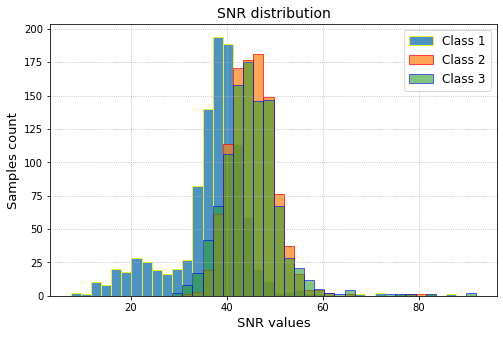

10346

<Figure size 432x288 with 0 Axes>

In [7]:
# ------> Signal-to-noise ratio

plt.figure(1, figsize=(8,5))

bins = np.histogram(np.hstack((wf_SNR_c1, wf_SNR_c2, wf_SNR_c3)), bins=40)[1]
                              
plt.hist(wf_SNR_c1, bins, label='Class 1', alpha=.8, edgecolor='yellow')
plt.hist(wf_SNR_c2, bins, label='Class 2', alpha=.7, edgecolor='red')
plt.hist(wf_SNR_c3, bins, label='Class 3', alpha=.6, edgecolor='blue')

plt.title("SNR distribution", fontsize=14)
plt.ylabel("Samples count", fontsize=13)
plt.xlabel("SNR values", fontsize=13)
plt.grid(which='both', linestyle=':')

plt.legend(fontsize=12)

plt.savefig("../../Figures/distribution_snr.pdf", format="pdf")
#plt.savefig("../../Figures/distribution_snr.eps", format="eps")

plt.show()
plt.figure(1).clear()
gc.collect()

### 5.2. Slope of the high frequency mode

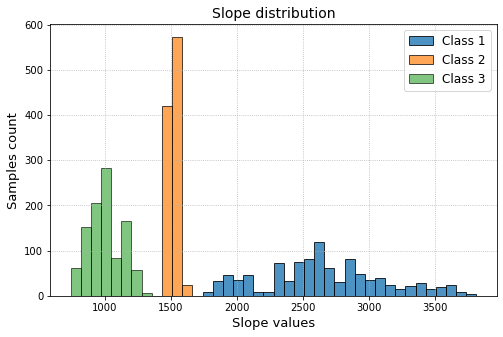

10488

<Figure size 432x288 with 0 Axes>

In [8]:
# ------> Slope of the high frequency mode

plt.figure(2, figsize=(8,5))

bins = np.histogram(np.hstack((Slope_c1, Slope_c2, Slope_c3)), bins=40)[1]

plt.hist(Slope_c1, bins=bins, label='Class 1', alpha=.8, edgecolor='black')
plt.hist(Slope_c2, bins=bins, label='Class 2', alpha=.7, edgecolor='black')
plt.hist(Slope_c3, bins=bins, label='Class 3', alpha=.6, edgecolor='black')

plt.title("Slope distribution", fontsize=14)
plt.ylabel("Samples count", fontsize=13)
plt.xlabel("Slope values", fontsize=13)
plt.grid(which='both', linestyle=':')

plt.legend(fontsize=12)

plt.savefig("../../Figures/distribution_slope.pdf", format="pdf")
#plt.savefig("../../Figures/distribution_slope.eps", format="eps")

plt.show()
plt.figure(2).clear()
gc.collect()

### 5.3. Waveform duration

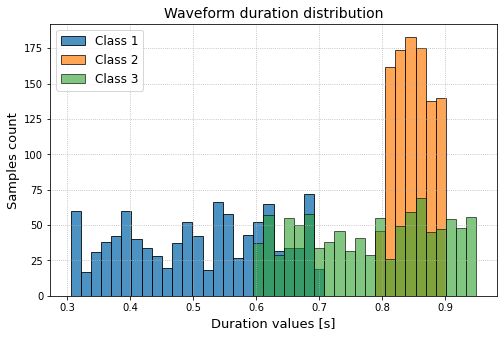

10658

<Figure size 432x288 with 0 Axes>

In [9]:
# ------> Waveform duration

plt.figure(3, figsize=(8,5))

bins = np.histogram(np.hstack((wf_duration_c1, wf_duration_c2, wf_duration_c3)), bins=40)[1]

plt.hist(wf_duration_c1, bins=bins, label='Class 1', alpha=.8, edgecolor='black')
plt.hist(wf_duration_c2, bins=bins, label='Class 2', alpha=.7, edgecolor='black')
plt.hist(wf_duration_c3, bins=bins, label='Class 3', alpha=.6, edgecolor='black')

plt.title("Waveform duration distribution", fontsize=14)
plt.ylabel("Samples count", fontsize=13)
plt.xlabel("Duration values [s]", fontsize=13)
plt.grid(which='both', linestyle=':')

plt.legend(fontsize=12)

plt.savefig("../../Figures/distribution_wfduration.pdf", format="pdf")
#plt.savefig("../../Figures/distribution_wfduration.eps", format="eps")

plt.show()
plt.figure(3).clear()
gc.collect()

### 5.4. Frequency range (f1-f0)

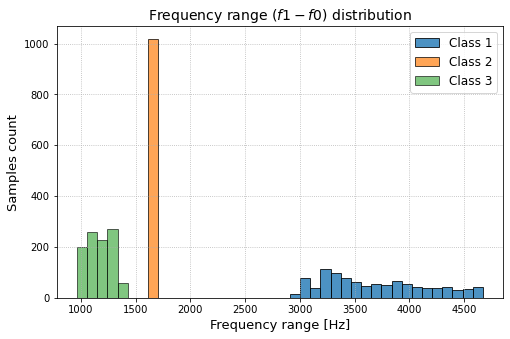

11934

<Figure size 432x288 with 0 Axes>

In [10]:
# ------> Initial frequencies

Deltaf_c1 = f_end_c1 - f_ini_c1
Deltaf_c2 = f_end_c2 - f_ini_c2
Deltaf_c3 = f_end_c3 - f_ini_c3

plt.figure(4, figsize=(8,5))

bins = np.histogram(np.hstack((Deltaf_c1, Deltaf_c2, Deltaf_c3)), bins=40)[1]

plt.hist(Deltaf_c1, bins=bins, label='Class 1', alpha=.8, edgecolor='black')
plt.hist(Deltaf_c2, bins=bins, label='Class 2', alpha=.7, edgecolor='black')
plt.hist(Deltaf_c3, bins=bins, label='Class 3', alpha=.6, edgecolor='black')

plt.title("Frequency range ($f1-f0$) distribution", fontsize=14)
plt.ylabel("Samples count", fontsize=13)
plt.xlabel("Frequency range [Hz]", fontsize=13)
plt.grid(which='both', linestyle=':')

plt.legend(fontsize=12)

#plt.savefig("../../Figures/distribution_Deltaf.pdf", format="pdf")
#plt.savefig("../../Figures/distribution_Deltaf.eps", format="eps")

plt.show()
plt.figure(4).clear()
gc.collect()